In [1]:
import numpy as np
import seaborn as sns
from pylab import rcParams
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import struct

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
#obtenidas del repositorio de la informacion de fashion_mnist
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [3]:
#funcion obtenida del ejemplo de lectura de la informacion en fashion_mnist
def read_fashion_mnist(images_path, labels_path):
    with open(labels_path, 'rb') as p:
        magic, n = struct.unpack('>II', p.read(8))
        labels = np.fromfile(p, dtype=np.uint8)
    with open(images_path, 'rb') as p:
        magic, num, rows, cols = struct.unpack(">IIII", p.read(16))
        images = np.fromfile(p, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


def mle(y, axis=1):
    return np.argmax(y, axis)


def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

In [4]:
def cross_entropy(outputs, y_target):
    return -np.sum(np.log(outputs) * y_target, axis=1)

In [5]:
def plot_product(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title('predicciones: %s' % CLASS_NAMES[y[idx]])
    plt.colorbar()
    plt.grid(False)
    plt.show()

def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Error')
    plt.xlabel('Vuelta')
    plt.show()

Se realizaron unos metodos para poder graficar el vector de probabilidades que se obtendran al final de la predicción, para esto se obtuvo el valor más alto de las probabilidades como predicción.

In [6]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAMES[predicted_label],
                                100*np.max(predictions_array),
                                CLASS_NAMES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  
def plot_image_grid(X_test, y_test, y_hat, num_rows=5, num_cols=3):
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_hat, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_hat,  y_test)

# Leyendo las imagenes

In [7]:
IMAGES_PATH = 'train-images-idx3-ubyte'
LABELS_PATH = 'train-labels-idx1-ubyte'

N_FEATURES = 28 * 28 # 28x28 pixels for the images
N_CLASSES = 10

In [8]:
X, y = read_fashion_mnist(IMAGES_PATH, LABELS_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Exploración de los datos leidos

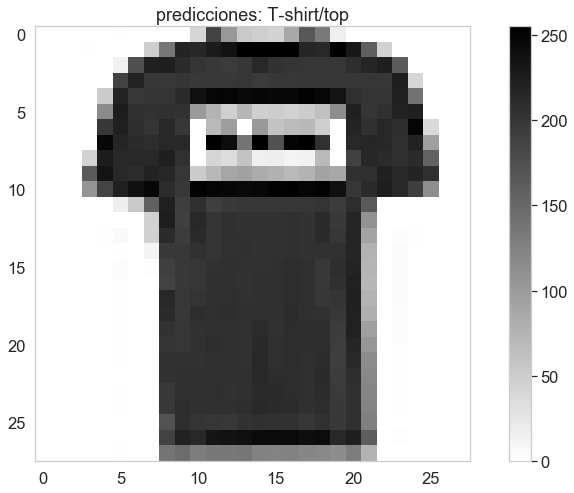

In [9]:
plot_product(X, y, idx=1)

In [10]:
X[1].reshape(28, 28)

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

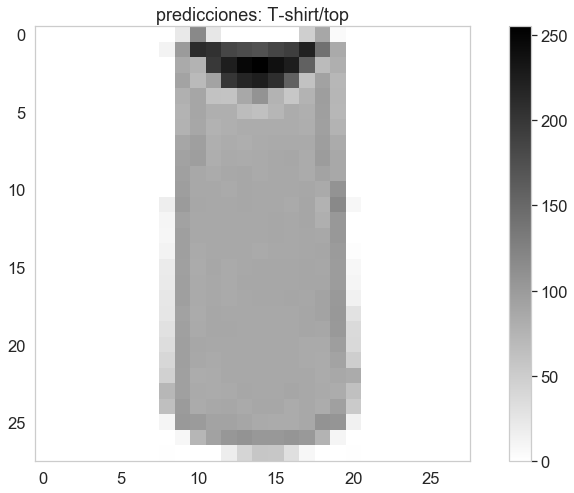

In [11]:
plot_product(X, y, idx=2)

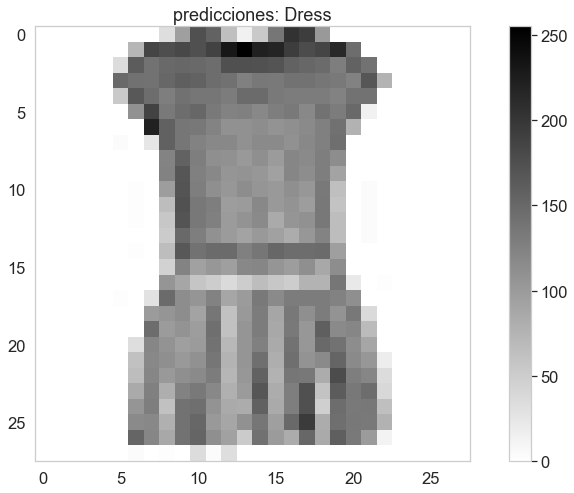

In [12]:
plot_product(X, y, idx=3)


# Funciones necesarias para poder implementar la red neuronal

## Sigmoide

$$\sigma (x) = \frac{1}{1+e^{-x}}$$



In [13]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

### Primera derivada de la sigmoide

Se utilizara para la implementacion de back propagation

$$\frac{d\sigma (x)}{d(x)} = \sigma (x)\cdot (1-\sigma(x))$$

In [14]:
def sigmoid_prime(z):
    sg = sigmoid(z)
    return sg * (1 - sg)

#### Para comprobar las funciones de la sigmoide vamos a realizar su gráfica para asegurarnos que esta bien

##### Las funciones deben de verse como la siguiente la imagén 

<img src="https://www.researchgate.net/profile/Vitali_Herrera-Semenets/publication/272816776/figure/fig17/AS:669412818444301@1536611861468/Grafica-de-funcion-sigmoide.png" width="60%">


Se utilizo la función de linspace de numpy para crear números impares entre -10 a 10 que son los que vamos a utilizar en el eje x para ver que nos devuelve nuestros valores de sigmoide y graficarlo

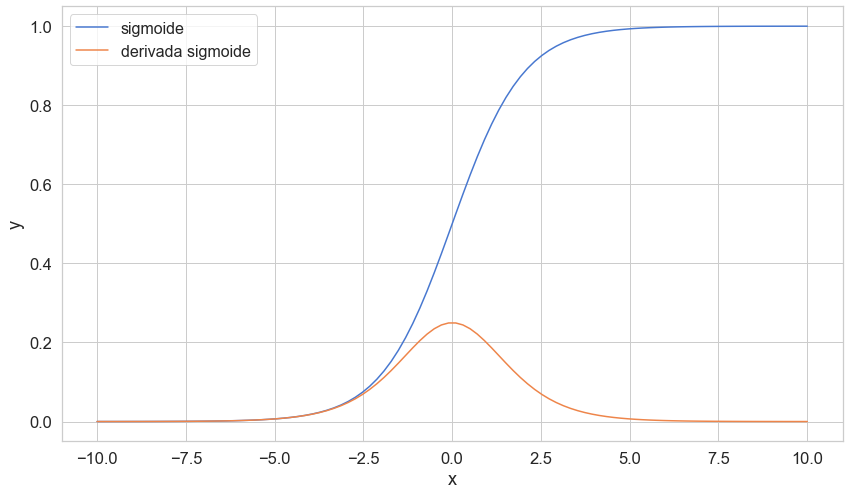

In [15]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_prime(x)

plt.plot(x, sig, label="sigmoide")
plt.plot(x, sig_prime, label="derivada sigmoide")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

## Softmax


$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{K}^{k=1}e^{z_k}} \text{for}\,j = 1,...,k$$

In [16]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [17]:
softmax(np.array([[0.99, 0.1, 0.234, 0.89]]))

array([[0.35906204, 0.14745089, 0.16859429, 0.32489277]])

# Implementación de red neuronal

Para cada vez que podemos ver la data se realiza el algoritmo de backpropagation, se calcula el error y el gradiente con respecto a los pesos. Por último se utiliza la tasa de aprendizaje para volver a calcular los pesos. La red neuronal a crear tiene una sola capa. Y las capas ocultas pueden ser variadas. 

In [20]:
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 epochs=500, learning_rate=0.01,
                random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.epochs = epochs
        self.learning_rate = learning_rate

    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_hidden_units, self.n_features))        
        w2 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_classes, self.n_hidden_units))
        return w1, w2
      
    def _forward(self, X):
        net_input = X.copy()
        net_hidden = self.w1.dot(net_input.T)
        act_hidden = sigmoid(net_hidden)
        net_out = self.w2.dot(act_hidden)
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out
    
    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        sigma3 = act_out - y
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        grad1 = sigma2.dot(net_input)
        grad2 = sigma3.dot(act_hidden.T)
        return grad1, grad2      

    def _error(self, y, output):
        error = cross_entropy(output, y)
        return 0.5 * np.mean(error)

    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        error = self._error(y, act_out)
        
        return error, grad1, grad2

    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return mle(net_out.T)
    
    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return softmax(act_out.T)

    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
                
        X_mbs = np.array_split(X_data, 25)
        y_mbs = np.array_split(y_data_enc, 25)
        
        for i in range(self.epochs):
            
            epoch_errors = []

            for Xi, yi in zip(X_mbs, y_mbs):
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

## Entrenamiento

El parámetro epochs controla cuántas veces el algoritmo "verá" los datos durante el entrenamiento. Luego establecemos el número de neuronas en las capas de entrada, ocultas y de salida: tenemos 2 números como entrada y 1 número como tamaño de salida. El parámetro de velocidad de aprendizaje controla la rapidez con que nuestra red neuronal aprenderá de los nuevos datos y olvidará lo que ya sabe. 

In [21]:
nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=70,
    epochs=800,
    learning_rate=0.0001,
    random_seed=RANDOM_SEED
).fit(X_train, y_train);

/Users/mafer/Documents/UVG/Cuarto/Primer semestre/Inteligencia/HT1/HojaTrabajo1-IA/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp


## Resultados

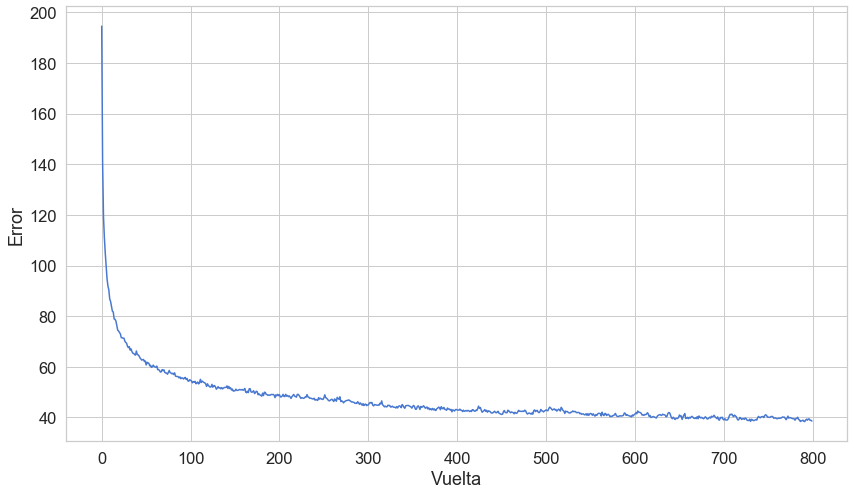

In [22]:
plot_error(nn)

En la gráfica del error podemos ver que a medida que ibamos realizando más vueltas el error disminuia que es justo lo que queremos, lo que se pudo haber realizado es que se ve que para algunas vueltas intermedias hay muchos picos, esto probablemente se pudo haber mejorado si le hubieramos aplicado alguna regularización. Nos pudo haber ayudado a aplanar un poco los datos y de esa formar disminuir el error que teniamos entre capa y capa. 

In [23]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 86.40%
Test Accuracy: 84.33%


/Users/mafer/Documents/UVG/Cuarto/Primer semestre/Inteligencia/HT1/HojaTrabajo1-IA/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Al observar los errores podemos ver que con los datos de entrenamiento se le llego al valor teorico de 85% sin envargo con los datos de prueba podemos ver una diferencia del 2%, esto puede ser también por la cantidad de datos que se hayan tomado para realizar el conjunto de datos de prueba. 

Sin embargo, el modelo no esta mal pues predice de buena manera con el poco tiempo que se tardo comparado con otros metodos

### Explorando predicciones

In [24]:
nn.predict_proba(X_test[1:2])

/Users/mafer/Documents/UVG/Cuarto/Primer semestre/Inteligencia/HT1/HojaTrabajo1-IA/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


array([[0.0854803 , 0.08529035, 0.08532222, 0.08528294, 0.08534377,
        0.08549818, 0.08541145, 0.0853373 , 0.23175051, 0.08528297]])

In [25]:
y_hat = nn.predict_proba(X_test)

/Users/mafer/Documents/UVG/Cuarto/Primer semestre/Inteligencia/HT1/HojaTrabajo1-IA/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


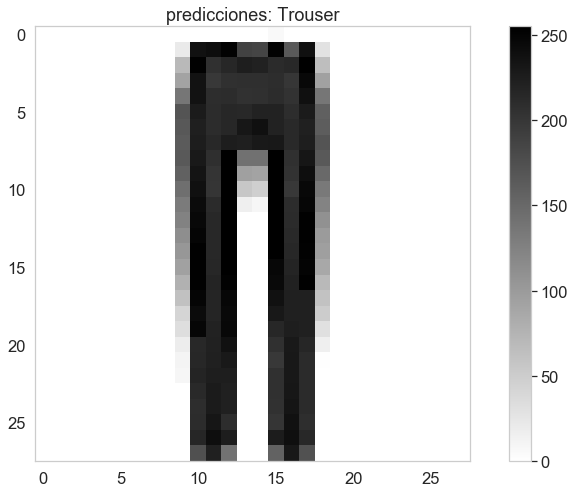

In [26]:
plot_product(X_test, y_test, idx=49)

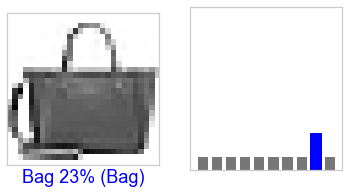

In [27]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

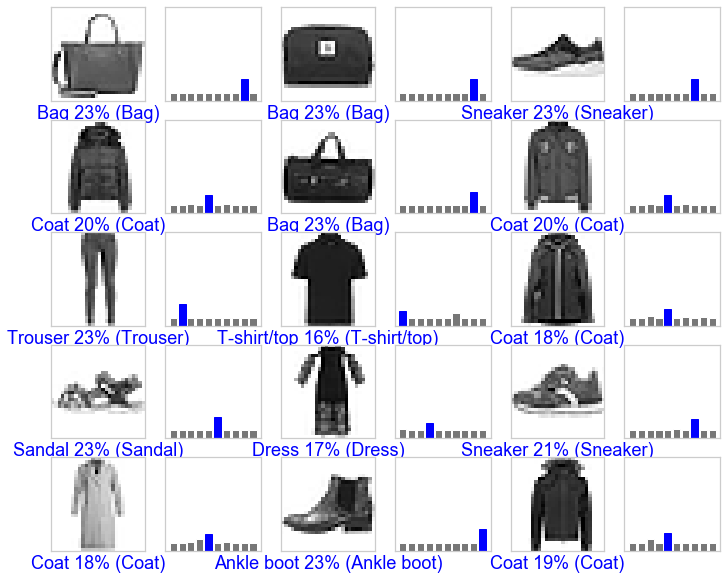

In [28]:
plot_image_grid(X_test, y_test, y_hat)

# Discución de los resultados

En nuestro algoritmo para graficar el vector de probabilidades, habia una condición en donde si la etiqueta que habia predicho era igual a la del conjunto de datos realez, la barra se iba a pintar de azul de lo contrario se pintaria de rojo. Podemos ver que para nuestro vector de resultados de probabilidades, efectivamente el algoritmo tomo el dato más alto. 

Creo que el algoritmo puede ser el más optimo ya que para realizar la implementación del mismo, en el paso del forward prop y backward step, esto se realiza por cada capa que tenga la neurona (incluyendo las ocultas), sin embargo al realizar el producto punto entre la sigmoide y nuestra matriz, nos podemos evitar un for y hacer que el algoritmo sea más eficiente. 

Por otro lado, entre más capas ocultas le agregamos podemos obtener un mejor resultando, ya que de esta forma le estamos agregando más comlejidad al algoritmo y las veces que podia ver la data el algoritmo no son muchas. Por lo que considero que algoritmo esta bien optimizado, dado a que usamos la semilla también nos evitamos tener que estar guardando el valor de theta cada vez que se corre. Algo que afecta al algoritmo también no solo la cantidad de neuronas o de veces que puede ver la data, es la tasa de aprendizaje del algoritmo. 

Con esto se hicieron diferentes pruebas para ver que valor era el que más influia, encontre un patron con las veces que se podia ver el algoritmo y las capas ocultas. 

Se inicio probando con una cantidad de capas ocultas de 50 y 300 vueltas y un learning rate de 0.001. A medida que se incrementaron las capas y las vueltas, el learning rate se quedo igual. Sin embargo en lugar de obtener un mejor resultado este disminuia. Por útltimo se cambio el learning rate a que fuera más pequeño, ya que podia haber la probabilidad de que este fuera avanzando muy rápido y se pasara de un valor que fuera el más adecuado. 

